In [50]:
import pandas as pd
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
le = preprocessing.LabelEncoder()
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

In [124]:
##Load Data
gpt3 = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/df_gpt3_t7.csv"
df_gpt3 = pd.read_csv(gpt3)
humans = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/analysis/experimentone_results.csv"
df_hum = pd.read_csv(humans)

df_hum['source'] = 'human'
df_gpt3['source'] = 'AI'

In [125]:


##clean columns 
df_gpt3 = df_gpt3.drop(columns = ['prompt_start', 'Q2_Response', 'Q3_Response'])
df_hum = df_hum.rename(columns={'scenario_clean':'scenario'})

df_gpt3['frame_loss'] = 1 - df_gpt3['frame_gain']

df_hum['option_selected_B'] = le.fit_transform(df_hum['option_selected']) ##0 = Prop A, 1 = Prop B
df_hum['option_selected_A'] = 1 - df_hum['option_selected_B'] ##1 = Prop A, 0 = Prop B
hum_col = ['ResponseId', 'frame', 'source', 'option_selected', 'rating', 'rating_num', 'reversed_rating_num', 'rationale', 'age_grouped', 'gender', 'ethnicity_grouped', 'education', 'continent_grouped', 'ADP_familiar', 'student', 'NEP_Score', 'scenario', 'option_selected_B', 'option_selected_A', 'frame_gain', 'frame_loss', 'ADP_No']
df_hum = df_hum[hum_col]

#combine
df_combined = pd.concat([df_hum, df_gpt3],axis = 0 ,ignore_index=True)

#clean scenario name
df_combined.scenario = df_combined.scenario.str.replace('humans', 'human')
df_combined.scenario = df_combined.scenario.str.replace('humanss', 'human')
df_combined.scenario = df_combined.scenario.str.replace('humans', 'human')
df_combined.scenario = df_combined.scenario.str.replace('animals', 'animal')


#clean temp and source
#df_combined['temp_alt'] = df_combined['temperature']
#df_combined['temp_alt'] = df_combined['temp_alt'] = df_combined['temp_alt'].where(~df_combined['temp_alt'].isna(), -1)
df_combined['source_AI'] = pd.Categorical(df_combined['source'], categories=['human', 'AI'], ordered=True)

#df_combined.to_csv('human_and_AI_combined.csv')

#df_combined.frame = df_combined.frame.str.replace('gain', 'Gain')
#df_combined.frame = df_combined.frame.str.replace('loss', 'Loss')

df_combined['combo'] = df_combined['combo'].fillna('Human Exp.')


#### Descriptive Stats

In [111]:
##chi-square for option selected 
contingency_table = pd.crosstab(df_combined['source'], df_combined['option_selected'])
chi, pval, _, _ = stats.chi2_contingency(contingency_table)
chi, pval

##check on this
contingency_table = pd.crosstab([df_combined['source'] , df_combined['frame'] ], df_combined['option_selected'])
chi, pval, _, _ = stats.chi2_contingency(contingency_table)
chi, pval

(217.78522470953328, 6.046084143166266e-47)

In [137]:
agg_data = no_an.groupby(['frame','source', 'scenario']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data

,frame,source,scenario,prop_A_mean,prop_A_std
0,Gain,AI,forest,0.398571,0.018505
1,Gain,AI,human,0.723333,0.018263
2,Gain,human,forest,0.828571,0.063705
3,Gain,human,human,0.735294,0.075661
4,Loss,AI,forest,0.376786,0.020477
5,Loss,AI,human,0.756757,0.015772
6,Loss,human,forest,0.821429,0.072379
7,Loss,human,human,0.588235,0.084404


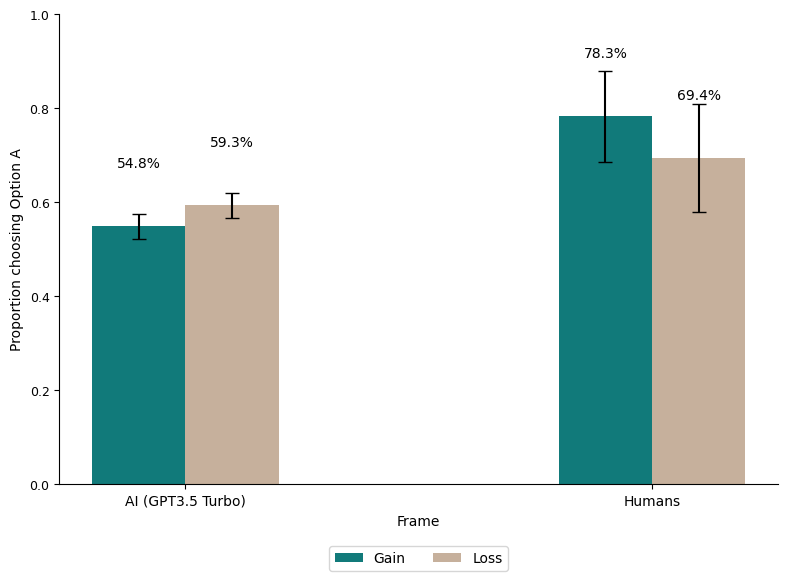

In [134]:
##GraphProportion Choosing Option A by Frame 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy as np 

df_combined.frame = df_combined.frame.replace('gain', 'Gain')
df_combined.frame = df_combined.frame.replace('loss', 'Loss')
no_an = df_combined[df_combined['scenario'] !='animal']

agg_data = no_an.groupby(['frame','source']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()
agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

plt.figure(figsize=(8, 5.5))

palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}

bars = sns.barplot(data=agg_data, x='source', y='prop_A_mean', hue  = 'frame' ,palette=palette, width = .4 ) ##, capsize=0.05) ##, width = 0.4)
bars.set_xticklabels(labels = ['AI (GPT3.5 Turbo)', 'Humans' ], rotation = 0, fontsize=10)
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.12,
              '{:.1%}'.format(yval), ha='center', va='bottom') 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)
    
sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize = 10)
plt.xlabel('Frame', labelpad = 5, fontsize = 10)
bars.set_yticks([0,.2,.4,.6,.8, 1])
plt.tight_layout()
plt.yticks(fontsize=9)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
plt.show()
fig = bars.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Cross Compare/figures/propA_frame_noan.png")


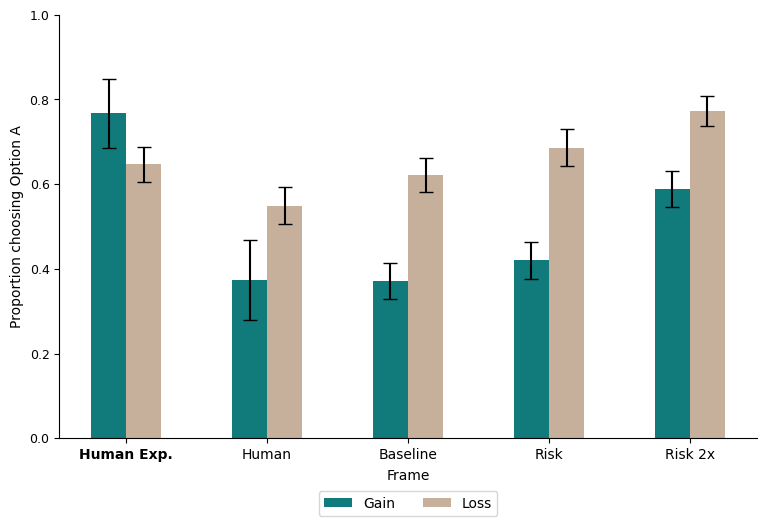

In [130]:
##Graph Proportion Choosing Option A by Frame and Combo
import seaborn as sns
import pandas as pd
import numpy as np

# Group and calculate proportions and standard errors
agg_data = df_combined.groupby(['frame','source', 'combo']).option_selected.agg(
    prop_A_mean=lambda x: np.mean(x == "Proposal A"),
    prop_A_std=lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()
agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

# Sort combos
label_ord = ['Human Exp.', 'Human', 'Baseline', 'Risk', 'Risk 2x']
agg_data.combo = pd.Categorical(agg_data.combo, categories=label_ord, ordered=True)
agg_data = agg_data.sort_values(by='combo')

plt.figure(figsize=(9, 5.5))
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}
bars = sns.barplot(data=agg_data, x='combo', y='prop_A_mean', hue='frame', palette=palette, width=0.5)

# Add error bars
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                  yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)

sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize=10)
plt.xlabel('Frame', labelpad=5, fontsize=10)
bars.set_yticks([0, .2, .4, .6, .8, 1])
plt.yticks(fontsize=9)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)

# Bold the 'Human Exp.' x-tick label
xtick_labels = bars.get_xticklabels()
for label in xtick_labels:
    if label.get_text() == 'Human Exp.':
        label.set_fontweight('bold')
#plt.tight_layout(

# Save the figure
plt.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Cross Compare/figures/propA_frame_hum_testype.png")
plt.show()


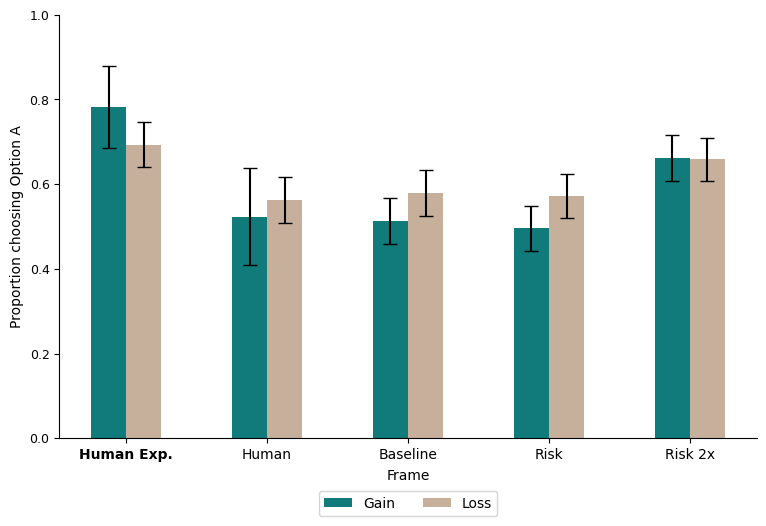

In [132]:
##Graph Proportion Choosing Option A by Frame and Combo
import seaborn as sns
import pandas as pd
import numpy as np

no_an = df_combined[df_combined['scenario'] !='animal']
# Group and calculate proportions and standard errors
agg_data = no_an.groupby(['frame','source', 'combo']).option_selected.agg(
    prop_A_mean=lambda x: np.mean(x == "Proposal A"),
    prop_A_std=lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()
agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

# Sort combos
label_ord = ['Human Exp.', 'Human', 'Baseline', 'Risk', 'Risk 2x']
agg_data.combo = pd.Categorical(agg_data.combo, categories=label_ord, ordered=True)
agg_data = agg_data.sort_values(by='combo')

plt.figure(figsize=(9, 5.5))
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}
bars = sns.barplot(data=agg_data, x='combo', y='prop_A_mean', hue='frame', palette=palette, width=0.5)

# Add error bars
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                  yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)

sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize=10)
plt.xlabel('Frame', labelpad=5, fontsize=10)
bars.set_yticks([0, .2, .4, .6, .8, 1])
plt.yticks(fontsize=9)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)

# Bold the 'Human Exp.' x-tick label
xtick_labels = bars.get_xticklabels()
for label in xtick_labels:
    if label.get_text() == 'Human Exp.':
        label.set_fontweight('bold')
#plt.tight_layout(

# Save the figure
plt.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Cross Compare/figures/propA_frame_hum_testype.png")
plt.show()


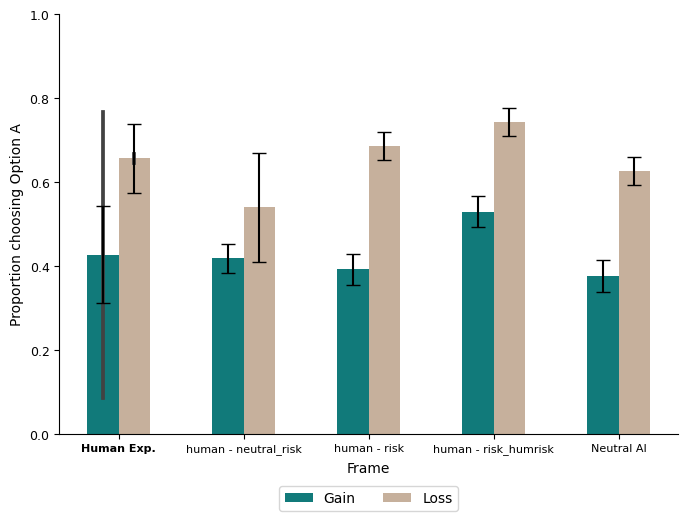

In [96]:
##GraphProportion Choosing Option A by Frame and Sys Role / Risk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy as np 

df_combined['sys_role']= df_combined['sys_role'].fillna("Human Exp.")
df_combined['risk']= df_combined['risk'].fillna("Human Exp.")

##df_forest = df_combined[df_combined['scenario'] == 'forest']
agg_data = df_combined.groupby(['frame','source', 'sys_role', 'risk']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()
agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

agg_data['variable'] = agg_data['sys_role'] + " - " + agg_data['risk']
order_test_scenario = agg_data['variable'].unique()
agg_data['variable'] = agg_data['variable'].replace('Human Exp. - Human Exp.', 'Human Exp.')
agg_data['variable'] = agg_data['variable'].replace('neutral_system - neutral_risk', 'Neutral AI')


#label_ord = ['Human Exp.', 'Human', 'Baseline', 'Risk', 'Risk 2x']
#agg_data.combo = pd.Categorical(agg_data.combo, categories =label_ord, ordered =True)
plt.figure(figsize=(7, 5))
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}
bars = sns.barplot(data=agg_data, x='variable', y='prop_A_mean', hue  = 'frame' ,palette=palette, width = .5 ) ##, capsize=0.05) # Adding hatches to bars where combo is 'Human Exp'
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)
sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize = 10)
plt.xlabel('Frame', labelpad = 5, fontsize = 10)
xtick_labels = bars.get_xticklabels()
for label in xtick_labels:
    if label.get_text() == 'Human Exp.':
        label.set_fontweight('bold')
bars.set_yticks([0,.2,.4,.6,.8,1])
plt.tight_layout()
plt.yticks(fontsize=9)
plt.xticks(fontsize=8)

plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
plt.show()
fig = bars.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Cross Compare/figures/propA_frame_hum_sys_role.png")

In [ ]:
##GraphProportion Choosing Option A by Frame and Sys Role / Risk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy as np 

df_forest = df_combined[df_combined['scenario'] == 'forest']
agg_data = df_forest.groupby(['frame','source', 'combo']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()
agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']
label_ord = ['Human Exp.', 'Human', 'Baseline', 'Risk', 'Risk 2x']
agg_data.combo = pd.Categorical(agg_data.combo, categories =label_ord, ordered =True)


plt.figure(figsize=(7, 5))

palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}
bars = sns.barplot(data=agg_data, x='combo', y='prop_A_mean', hue  = 'frame' ,palette=palette, width = .5 ) ##, capsize=0.05) # Adding hatches to bars where combo is 'Human Exp'
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    combo_value = agg_data['combo'].iloc[i]
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)
    
sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize = 10)
plt.xlabel('Frame', labelpad = 5, fontsize = 10)
xtick_labels = bars.get_xticklabels()
for label in xtick_labels:
    if label.get_text() == 'Human Exp.':
        label.set_fontweight('bold')
bars.set_yticks([0,.2,.4,.6,.8,1])
plt.tight_layout()
plt.yticks(fontsize=9)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
plt.show()
fig = bars.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Cross Compare/figures/propA_frame_hum_testype_andFOREST.png")

#### Regression 

In [6]:
#function for signficance 
def sig_effect(pvalue):
    if pvalue <= .01:
        return f"""significant at 1% level"""
    elif pvalue <= .05:
        return f"""significant at 5% level"""
    elif pvalue <= .1:
        return f"""significant at 10% level"""
    else:
        return "not significant"


### H4: 

In [7]:
### NOTES FROM DALLAS 
##assumption of equal variance 
##could affect power 
##issues with confounding 

##caveat --> why this was better strategy 

In [81]:
##Running Log Models 

logit_reg_combined = smf.logit('option_selected_A ~ frame_gain * source_AI + frame_gain ', data = df_combined).fit()
print(logit_reg_combined.summary())

logit_reg_combined2 = smf.logit('option_selected_A ~ frame_gain * source_AI + scenario ', data = df_combined).fit()

print(logit_reg_combined2.summary())

logit_reg_temp = smf.logit('option_selected_A ~ frame_gain * source_AI + scenario + temp_alt ', data = df_combined).fit()
print(logit_reg_temp.summary())


Optimization terminated successfully.
         Current function value: 0.649902
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                 3016
Model:                          Logit   Df Residuals:                     3012
Method:                           MLE   Df Model:                            3
Date:                Fri, 18 Aug 2023   Pseudo R-squ.:                 0.05527
Time:                        15:50:56   Log-Likelihood:                -1960.1
converged:                       True   LL-Null:                       -2074.8
Covariance Type:            nonrobust   LLR p-value:                 1.916e-49
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.6035      0.210      2.871      0.004      

In [10]:
logit_reg = smf.logit('option_selected_rev ~ frame + source + scenario', df_combined).fit()
print("frame p-vale:", logit_reg.pvalues[1])
print("\nsignficicant effect? --> ", sig_effect(logit_reg.pvalues[1]))
logit_reg.summary()

Optimization terminated successfully.
         Current function value: 0.620867
         Iterations 5
frame p-vale: 2.483177736339205e-09

signficicant effect? -->  significant at 1% level


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     option_selected_rev   No. Observations:                 1546
Model:                           Logit   Df Residuals:                     1541
Method:                            MLE   Df Model:                            4
Date:                 Fri, 11 Aug 2023   Pseudo R-squ.:                 0.06572
Time:                         11:25:17   Log-Likelihood:                -959.86
converged:                        True   LL-Null:                       -1027.4
Covariance Type:             nonrobust   LLR p-value:                 3.241e-28
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.7623      0.127     -5.986      0.000      -1.012      -0.513
frame[T.loss]          0.6553      0.110      5.963      0.000       0.440       0.871
source[T.human]        0.5842      0.201      2.904      0.004       0.190       0.978
scenario[T.forest]     1.4744      0.386      3.815      0.000       0.717       2.232
scenario[T.human]      1.1148      0.131      8.488      0.000       0.857       1.372
======================================================================================
"""

In [60]:
logit_reg = smf.logit('option_selected_rev ~ frame * source', df_combined).fit()
logit_reg.summary()

Optimization terminated successfully.
         Current function value: 0.612555
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     option_selected_rev   No. Observations:                 1546
Model:                           Logit   Df Residuals:                     1538
Method:                            MLE   Df Model:                            7
Date:                 Thu, 10 Aug 2023   Pseudo R-squ.:                 0.07823
Time:                         05:40:43   Log-Likelihood:                -947.01
converged:                        True   LL-Null:                       -1027.4
Covariance Type:             nonrobust   LLR p-value:                 2.233e-31
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.9500      0.137     -6.943      0.000      -1.218      -0.682
frame[T.loss]                     0.8105      0.118      6.855      0.000       0.579       1.042
source[T.human]                   1.6374   7.84e+06   2.09e-07      1.000   -1.54e+07    1.54e+07
scenario[T.animals]               0.2242   7.84e+06   2.86e-08      1.000   -1.54e+07    1.54e+07
scenario[T.forest]                1.1384   7.84e+06   1.45e-07      1.000   -1.54e+07    1.54e+07
scenario[T.human]                 1.2610      0.143      8.839      0.000       0.981       1.541
scenario[T.humans]                0.2748   7.84e+06   3.51e-08      1.000   -1.54e+07    1.54e+07
frame[T.loss]:source[T.human]    -1.3675      0.340     -4.025      0.000      -2.033      -0.702
=================================================================================================
"""

In [43]:
# Convert categorical variables into dummy/indicator variables. We'll use 'AI' as our reference group.
df_combined['frame'] = pd.get_dummies(df_combined['frame'], drop_first=True) # Assuming 'Loss' as reference
#####df_combined['scenario'] = pd.get_dummies(df_combined['scenario'], drop_first=True) # Assume one scenario, e.g., 'Animals', as reference
df_combined['source'] = pd.get_dummies(df_combined['source'], drop_first=True) # 'AI' as reference

X = df_combined[['frame', 'source']]
X = sm.add_constant(X)  # Adds a constant (intercept) to your predictor variables

y_option = df_combined['option_selected']

model_option = sm.Logit(y_option, X).fit()
print(model_option.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [35]:
y_option = df_combined['option_selected']
X = 'frame'
model_option = sm.Logit(y_option, X).fit()
print(model_option.summary())

NameError: name 'X' is not defined